In [20]:
# http://math.ucr.edu/home/baez/coarse_graining.pdf

import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx

def stochasticSection(p):
    returnVal = p.T
    (r,c) = p.shape
    returnVal = returnVal*0
    for i in range(r):
        nonzeros = p[i].nonzero()[0]
        total = len(nonzeros)
        for j in nonzeros:
            toAssign=(1.0)/(total+.0)
            returnVal[j,i]=toAssign
    return returnVal

def block_diagonal(matrices, dtype=tf.float32):
    matrices = [tf.convert_to_tensor(matrix, dtype=dtype) for matrix in matrices]
    blocked_rows = tf.Dimension(0)
    blocked_cols = tf.Dimension(0)
    batch_shape = tf.TensorShape(None)
    for matrix in matrices:
        full_matrix_shape = matrix.get_shape().with_rank_at_least(2)
        batch_shape = batch_shape.merge_with(full_matrix_shape[:-2])
        blocked_rows += full_matrix_shape[-2]
        blocked_cols += full_matrix_shape[-1]
    ret_columns_list = []
    for matrix in matrices:
        matrix_shape = tf.shape(matrix)
        ret_columns_list.append(matrix_shape[-1])
    ret_columns = tf.add_n(ret_columns_list)
    row_blocks = []
    current_column = 0
    for matrix in matrices:
        matrix_shape = tf.shape(matrix)
        row_before_length = current_column
        current_column += matrix_shape[-1]
        row_after_length = ret_columns - current_column
        row_blocks.append(tf.pad(
            tensor=matrix,
            paddings=tf.concat(
                [tf.zeros([tf.rank(matrix) - 1, 2], dtype=tf.int32),
                     [(row_before_length, row_after_length)]],
                    axis=0)))
    blocked = tf.concat(row_blocks, -2)
    blocked.set_shape(batch_shape.concatenate((blocked_rows, blocked_cols)))
    return blocked

# make a syntactic open Markov Process by specifying the number X of possibilities
# as well as arrays S and T that label which of the possibilities are connected to input and output lines
def OpenMarkovProcesses(X,S,T):
    class OpenMarkovProcess():
        # a particular instance of the class has the explicit infinitesimal generator H and the input and output rates
        def __init__(self,H,inflow,outflow,asFullSize=False):
            self.H=H
            self.mySyntax=OpenMarkovProcess
            shape = self.mySyntax.size
            # can pass inflow and outflow as either tensors of length X or with only length the sizes of S/T.
            # these get embedded into R^X using the data of S \to X and T \to X
            if (asFullSize):
                self.inflow=inflow
                self.outflow=outflow
            else:
                self.inflow=tf.scatter_nd(self.mySyntax.inputs,inflow,shape)
                self.outflow=tf.scatter_nd(self.mySyntax.outputs,outflow,shape)
        # approximate e^{Ht} p as (1+H)p and then possibly renormalize to a probability distribution
        def timeStep(self,timestep,p_init):
            approxP = p_init + tf.tensordot(self.H * timestep, p_init, axes=1)
            approxP = approxP +self.inflow * timestep - self.outflow * timestep
            # if don't want normalization
            #return approxP
            # if want normalization without net in or outflow of probability
            mySum = tf.tensordot(approxP,OpenMarkovProcess.myOnes,axes=1)
            #mySum = tf.cumsum(approxP)
            return approxP/mySum
        # divide timeStep into intervals smaller than eps, rather than one step Euler method
        def timeFlow(self,timestep,p_init,eps=.1):
            divisions=math.floor(timestep/eps)
            newTimeStep = timestep/divisions
            newP = p_init
            for i in range(divisions):
                newP = self.timeStep(newTimeStep,newP)
            return newP
        #def identifySystem(sequenceOfProbs)
        # return a specific object from learning H, inflow and outflow
        # ----- Building other open Markov processes from smaller ones -----
        # tensor product of these one morphisms, does disjoint union of the inputs and outputs
        # these are labelled by their indices in 0-size which is dimension of the matrices
        def disjointUnion(self,other):
            inputIndices = self.mySyntax.Sindices
            inputIndices = np.append(inputIndices,self.mySyntax.mySize+other.mySyntax.Sindices)
            outputIndices = self.mySyntax.Tindices
            outputIndices = np.append(outputIndices,self.mySyntax.mySize+other.mySyntax.Tindices)
            # X is the disjoint union of the self and other
            # use SIndices and TIndices as arrays to make the input and outputs for the combined system
            newSyntax = OpenMarkovProcesses(self.mySyntax.mySize+other.mySyntax.mySize,inputIndices,outputIndices)
            newH = block_diagonal([self.H,other.H])
            shape = tf.constant([self.mySyntax.mySize+other.mySyntax.mySize])
            firstBatch = np.arange(self.mySyntax.mySize)
            firstBatch = tf.constant(firstBatch.reshape(-1,1))
            secondBatch = np.arange(other.mySyntax.mySize)+self.mySyntax.mySize
            secondBatch = tf.constant(secondBatch.reshape(-1,1))
            newInFlow=tf.scatter_nd(firstBatch,self.inflow,shape)
            newInFlow=newInFlow+tf.scatter_nd(secondBatch,other.inflow,shape)
            newOutFlow=tf.scatter_nd(firstBatch,self.outflow,shape)
            newOutFlow = newOutFlow+tf.scatter_nd(secondBatch,other.outflow,shape)
            return newSyntax(newH,newInFlow,newOutFlow,True)
        # first form the disjoint union of the two morphisms and then glue together which outputs of self
        # go with which inputs of other, then eliminate these from the disjoint union, this leaves the composition
        # with it's newH , newInFlow and newOutFlow
        #def composeMorphisms(self,other):
        # apply a 2 morphism specified by the lumping myP, actually p_* not p in the notation of the paper
        # assume lumpable, if it is not returns garbage without failing loudly so caution when using it
        def coarseGrain(self,myP):
            # size of X is decided by shape of myP, inputs and outputs are same in number
            (r,c) = myP.shape
            myS = myP * self.S
            myT = myP * self.T
            newSyntax = OpenMarkovProcesses(r,myS,myT)
            myStS = stochasticSection(myP)
            newH = tf.matmul(myP,self.H)
            newH = tf.matmul(newH,myStS)
            # use myP to make newInFlow and newOutFlow
            # toReturn = newSyntax(newH,newInFlow,newOutFlow)
            return 0
        # display the network as a directed graph with blue for vertices connected to input lines, red output
        def displayGraph(self,session,cutoff=0):
            numVertices=self.mySyntax.mySize
            inputVertices=self.mySyntax.Sindices
            outputVertices=self.mySyntax.Tindices
            G = nx.DiGraph()
            colors=["black" for number in range(numVertices)]
            for i in inputVertices:
                colors[i]="blue"
            for i in outputVertices:
                colors[i]="red"
            myH = sess.run(self.H)
            for i in range(numVertices):
                for j in range(numVertices):
                    edgeWeight=myH[i,j]
                    if (np.abs(edgeWeight)>cutoff):
                        G.add_edge(i,j,weight=edgeWeight)
            plt.subplot(121)
            nx.draw_networkx(G, node_color=colors,with_labels=True, font_weight='bold')
    OpenMarkovProcess.myOnes=tf.constant(1.0,shape=(X,))
    OpenMarkovProcess.mySize=X
    OpenMarkovProcess.size=tf.constant([X])
    OpenMarkovProcess.Sindices = S
    OpenMarkovProcess.inputs=tf.constant(S.reshape(-1,1))
    OpenMarkovProcess.Tindices = T
    OpenMarkovProcess.outputs=tf.constant(T.reshape(-1,1))
    return OpenMarkovProcess

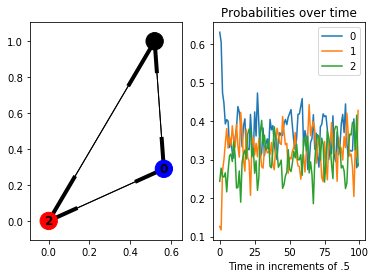

(array([[ 0.10512483,  0.34100223,  0.35025764],
       [ 0.55687547,  0.83339727,  0.38350213],
       [ 0.0611856 ,  0.13560247,  0.15781939]], dtype=float32), array([ 0.3347221 ,  0.42608085,  0.23919705], dtype=float32))
[ 0.1  0.   0.   0.1  0.   0. ]
[ 0.    0.    0.01  0.    0.    0.01]
[[ 0.48837721  0.46259439  0.20970345  0.          0.          0.        ]
 [ 0.68548274  0.50818443  0.75508642  0.          0.          0.        ]
 [ 0.93162262  0.03602397  0.23220015  0.          0.          0.        ]
 [ 0.          0.          0.          0.48837721  0.46259439  0.20970345]
 [ 0.          0.          0.          0.68548274  0.50818443  0.75508642]
 [ 0.          0.          0.          0.93162262  0.03602397  0.23220015]]


In [21]:
sess = tf.Session()
xSize=3
# 3 possibilities with input at site 0 and out at site 2
myProcesses = OpenMarkovProcesses(xSize,np.array([0]),np.array([2]))
# the infinitesimal stochastic rates, input and output rates are provided
myH = tf.random_uniform(shape=(xSize,xSize))
myInRates = tf.constant([.1])
myOutRates = tf.constant([.01])
myProcess = myProcesses(myH,myInRates,myOutRates)
myProcess.displayGraph(sess,.1)
plt.subplot(122)
# simulate an evolution for a time of .5 starting with two different starting
pInit = tf.placeholder(tf.float32, shape=(xSize, ))
pInitTest = [.93,0.05,0.02]
newProb = myProcess.timeFlow(.5,pInit)
maxEnt=np.full((xSize,),1.0/xSize)
#print(sess.run((myH,newProb),{pInit: pInitTest}))
# Graph the probabilities of the 3 possibilities with time increments of .5 for timeLength time steps
timeLength=100
resultPlot=np.zeros((timeLength,3))
timeLength=range(timeLength)
for i in timeLength:
    pInitTest=sess.run(newProb,{pInit: pInitTest})
    resultPlot[i,:]=pInitTest
plt.plot(timeLength,resultPlot[:,0],label='0')
plt.plot(timeLength,resultPlot[:,1],label='1')
plt.plot(timeLength,resultPlot[:,2],label='2')
plt.title("Probabilities over time")
plt.xlabel("Time in increments of .5")
plt.legend()
plt.show()
# start with uniform distribution on the 3 possibilities and go for t=.5
print(sess.run((myH,newProb),{pInit: maxEnt}))
# two copies of the same system
newProcess=myProcess.disjointUnion(myProcess)
print(sess.run(newProcess.inflow))
print(sess.run(newProcess.outflow))
print(sess.run(newProcess.H,{pInit: [.93,0.05,0.02]}))

In [40]:
myP = np.array([[1.0,0,0,0,0],[0,1,0,0,0],[0,0,1,1,0],[0,0,0,0,1]])
s=stochasticSection(myP)
print(s)
print(np.mat(myP)*np.mat(s))

[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   0.5  0. ]
 [ 0.   0.   0.5  0. ]
 [ 0.   0.   0.   1. ]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
